In [1]:
import chess
import sklearn.ensemble
from scipy.special import entr

import pdb

board = chess.Board()

In [2]:
print(board)

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


In [3]:
list(board.legal_moves)

[Move.from_uci('g1h3'),
 Move.from_uci('g1f3'),
 Move.from_uci('b1c3'),
 Move.from_uci('b1a3'),
 Move.from_uci('h2h3'),
 Move.from_uci('g2g3'),
 Move.from_uci('f2f3'),
 Move.from_uci('e2e3'),
 Move.from_uci('d2d3'),
 Move.from_uci('c2c3'),
 Move.from_uci('b2b3'),
 Move.from_uci('a2a3'),
 Move.from_uci('h2h4'),
 Move.from_uci('g2g4'),
 Move.from_uci('f2f4'),
 Move.from_uci('e2e4'),
 Move.from_uci('d2d4'),
 Move.from_uci('c2c4'),
 Move.from_uci('b2b4'),
 Move.from_uci('a2a4')]

In [4]:
import numpy as np

def piece2vec(piece_str):
    """Converts a string representation of a piece to a one-hot representation"""
    
    piece_dictionary = { #ignore empty position
                        'B': 0, 
                        'K': 1,
                        'N': 2,
                        'P': 3,
                        'Q': 4,
                        'R': 5,
                        'b': 6,
                        'k': 7,
                        'n': 8,
                        'p': 9,
                        'q': 10,
                        'r': 11}
    
    piece_vec = np.zeros(len(piece_dictionary)) > 0
    
    if piece_str in piece_dictionary:
        piece_vec[piece_dictionary[piece_str]] = True
    
    return piece_vec


def board2vec(board):
    """Converts a board object to a 12 pieces x rows x columns one-hot representation"""
    board_state = str(board)

    # print(board_state)
    board_state = board_state.split('\n')
    board_state = [row.split(' ') for row in board_state]

    board_vector = np.zeros([12, 8, 8])

    # for every row
    for i in range(0, len(board_state)):
        #for every column
        for j in range(0, len(board_state[0])):
            piece_str = board_state[i][j]

            board_vector[piece2vec(piece_str), i,j] = 1

    return [board_vector, board.turn]
            
def vec2board(board, turn):    
    """Converts a 12 pieces x rows x columns one-hot representation to a board object"""
#     todo, not necessary
    pass


def board2vec_next_moves(board):
    """Returns a list of next legal moves as board vectors"""
    
    next_moves_vec = list()
    
    for move in board.legal_moves:
        board_tmp = board.copy()
        board_tmp.push(move)
        
        next_move_vec = board2vec(board_tmp)
        next_moves_vec.append(next_move_vec)
        
    return next_moves_vec

def board2vec_history(board):
    
    move_list = list()
    
    isempty = False
    c = 0
    while not isempty:
        c+=1
        move_list.append(board2vec(board))
        try:
            board.pop()
        except:
            isempty = True
            
    return move_list[::-1]
    
    
def who_won(board):
    """Returns who won 1: white, 0: tie, -1: black"""
    win_dict = {'1-0':1, '1/2-1/2':-1, '0-1':0}
    
    return win_dict[board.result()]

In [5]:
next_moves_vec = board2vec_next_moves(board)


In [6]:
def pick_rando_move(board):
    legal_moves = list(board.legal_moves)
    move_ind = np.random.choice(len(legal_moves))
    
    return legal_moves[move_ind]

class RandoBot(object):
    def __init__(self):
        pass
    
    def choose_move(self, board):
        return pick_rando_move(board)

class SKLearnBot(object):
    def __init__(self, model, state='explore'):
        self.model = model
        self.state = 'explore'
        
    def choose_move(self, board):
        next_moves_list = board2vec_next_moves(board)
        
        move_scores = np.zeros(len(next_moves_list))
        
        moves_flat = [move[0].flatten() for move in next_moves_list]
        moves_flat = np.vstack(moves_flat)
        
        scores = self.model.predict_proba(moves_flat)
        
        if self.state == 'explore':
            entropy = entr(scores).sum(axis=1)/np.log(2)
            ind = np.argmax(entropy)
        elif self.state == 'exploit':
            ind = np.argmax(scores[:,1])
        elif self.state == 'wexploit': #weighted exploitation
            scores = scores[:,1]
            scores = scores/sum(scores)
            ind = np.random.choice(np.arange(0, len(scores)), p = scores)
        
        legal_moves = list(board.legal_moves)
        
        return legal_moves[ind]
                                       
    def train_from_board(self, boards):
#       need to finish
        
        all_moves = list()
        all_won_game = list()
        
        for board in boards:
            #do this so we dont screw up the board objects outside of this
            board = board.copy()
            
            winner = who_won(board);
            moves = board2vec_history(board)
            
            moves_flat = [move[0].flatten() for move in moves]
            moves_flat = np.vstack(moves_flat)
            
            whose_turn = np.array([move[1] for move in moves])
            
            winning_moves = whose_turn == winner
            
            all_moves.append(moves_flat)
            all_won_game.append(winning_moves)
            
        all_moves = np.vstack(all_moves)
        all_won_game = np.hstack(all_won_game)
        
        self.model.fit(all_moves, all_won_game)
        

In [7]:
def play_game(board, player1, player2, verbose=False):
    players = [player1, player2]
    
    turn = 0
    while not board.is_game_over():
        if verbose: print(turn)
        
        moving_player = players[board.turn]
        move = moving_player.choose_move(board)
        board.push(move)
        
        turn +=1
        
    return board, turn

393
214
432
402
370
239
248
black won
341
286
108
black won
478
438
387
337
333
242
558
342
407
393
300
425
390
118
black won
437
302
488
455
368
354
580
336
352
454
324
313
163
white won
342
440
506
479
253
301
424
447
174
black won
556
468
504
384
black won
263
68
black won
404
404
299
394
240
498
411
397
298
320
563
423
431
117
white won
343
648
335
709
428
294
574
226
260
356
322
42
black won
305
300
468
333
363
55
white won
512
414
249
151
white won
410
178
black won
393
483
325
348
327
519
518
194
black won
409
361
367
369
241
white won
437
384
371
112
black won
591
344
342
407
456
312
453
370
318
472
487
233
420
402
389
508
398
370
72
black won
303
285
471
408
499
259
212
239
white won
359
378
538
568
368
417
192
black won
307
374
427
317
373
321
396
123
white won
181
white won
397
318
283
white won
524
419
white won
478
572
486
33
white won


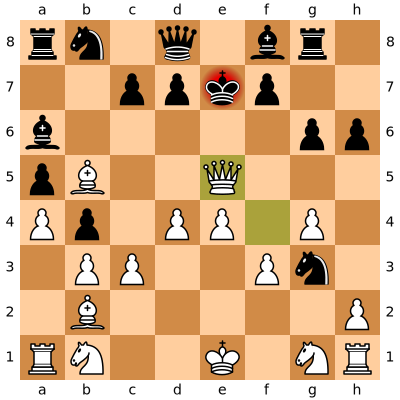

In [8]:
p1 = RandoBot()

board_list = list()

black_won = 0
white_won = 0

while not (black_won > 10 and white_won > 10):

    board = chess.Board()
    final_board, turn = play_game(board, p1, p1)

    print(turn)
    winner = who_won(final_board)
    
    if winner == 1:
        white_won += 1
        board_list.append(final_board)
        print('white won')
    elif winner == 0:
        black_won += 1
        board_list.append(final_board)
        print('black won')

final_board

In [ ]:
p_bot = SKLearnBot(sklearn.ensemble.RandomForestClassifier(n_estimators=500))

p_bot.train_from_board(board_list)



In [ ]:
# while len(train_board_list) < 500:
p_bot.state = 'wexploit'

winner = -1
tot_wins = 10
n_wins = 0

while n_wins < tot_wins:
    board = chess.Board()
    final_board, turn = play_game(board, p_bot, p_bot)

    print(turn)
    print(who_won(final_board))

    winner = who_won(final_board)

    if winner != -1:
        n_wins += 1
        board_list.append(final_board)
        p_bot.train_from_board(board_list)

final_board

319
1
412
-1


In [ ]:
p1 = RandoBot()

p_bot.state = 'exploit'

board_list = list()

black_won = 0
white_won = 0

n_games = 0
while n_games < 50:

    board = chess.Board()
    final_board, turn = play_game(board, p1, p_bot)

    print(turn)
    winner = who_won(final_board)
    
    if winner == 1:
        white_won += 1
        board_list.append(final_board)
        print('white won')
    elif winner == 0:
        black_won += 1
        board_list.append(final_board)
        print('black won')

    n_games +=1
    
final_board